In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from miditok import Structured, TokenizerConfig, TokSequence
import torch
from pathlib import Path
from ic.curves import Interpolator
from ic.curves.weight import Hann
import symusic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, Audio
# from ic.eval_ import get_all_token_ics_batik

Load a performance and the token IC's computed with the PIA model

In [3]:
piece = 'kv331_1'
midi_file = Path(f'/share/hel/home/mathias/datasets/batik_plays_mozart/midi/{piece}.mid')
score = symusic.Score(midi_file)
# force first note to start at t=0
for n in score.tracks[0].notes:
    n.time -= score.tracks[0].notes[0].time
tempo = score.tempos[0]
assert len(score.tempos) == 1 and score.tempos[0].time == 0 

piece_dict = torch.load('all_ics.pt')
tok_ics = piece_dict[piece]['tok_ics'][:-1]


In [4]:
score.tracks[0].notes[1]

Note(time=749, duration=597, pitch=57, velocity=32)

Create [Structured MIDI Encoding](https://arxiv.org/pdf/2107.05944.pdf) tokenzier using [MidiTok](https://github.com/Natooz/MidiTok). As opposed to the original implimentation of Structured MIDI Encoding that uses physical time, MidiTok uses symbolic score time (beats are divided in a number of subbeats).
We, therefore, set the beat_resolution to the number of ticks per quarter as defined in the midifile. This creates a vocabulary which is inadmissalbly large for training purposes, but can be used for demonstrating IIC curves.  

In [5]:
pitch_range = (21,108)
config = TokenizerConfig(
    pitch_range=pitch_range,
    beat_res={(0, 40): score.tpq},
    num_velocities=127,
    use_chords=False,
    use_programs=False
)
tokenizer = Structured(config)
ticks_per_second = tokenizer.time_division*1e6 / score.tempos[0].mspq 
tok_sequence = tokenizer(score)[0]
# NOTE: miditok uses (time_shift_1,pitch_1,velocity_1,duration_1,time_shift_2,pitch_2,velocity_2,duration_2, ...)
# with first time_shift_1 representing the onset of the first note. Altough this is more general, it doesn't follow the official "timeshift" defintion of
# which is instead (pitch_1,velocity_1,duration_1,time_shift_1,pitch_2,velocity_2,duration_2,time_shift_2, ...)  Structured MIDI encoding...
# such that first note's onset is at time 0.
tok_sequence = TokSequence(
    tokens=tok_sequence.tokens[1:-3],
    ids=tok_sequence.ids[1:-3],
    events=tok_sequence.events[1:-3]
)
tok_sequence

TokSequence(tokens=['Pitch_73', 'Velocity_59', 'Duration_1.207.480', 'TimeShift_1.269.480', 'Pitch_57', 'Velocity_32', 'Duration_1.117.480', 'TimeShift_0.0.1', 'Pitch_64', 'Velocity_25', 'Duration_1.53.480', 'TimeShift_1.212.480', 'Pitch_74', 'Velocity_46', 'Duration_0.231.480', 'TimeShift_0.10.480', 'Pitch_59', 'Velocity_27', 'Duration_0.207.480', 'TimeShift_0.237.480', 'Pitch_73', 'Velocity_57', 'Duration_1.42.480', 'TimeShift_0.23.480', 'Pitch_64', 'Velocity_32', 'Duration_0.231.480', 'TimeShift_0.7.480', 'Pitch_57', 'Velocity_33', 'Duration_0.410.480', 'TimeShift_0.478.480', 'Pitch_76', 'Velocity_60', 'Duration_0.459.480', 'TimeShift_0.17.480', 'Pitch_61', 'Velocity_49', 'Duration_0.476.480', 'TimeShift_0.35.480', 'Pitch_64', 'Velocity_28', 'Duration_0.381.480', 'TimeShift_1.383.480', 'Pitch_76', 'Velocity_62', 'Duration_1.24.480', 'TimeShift_0.26.480', 'Pitch_61', 'Velocity_38', 'Duration_0.186.480', 'TimeShift_0.9.480', 'Pitch_64', 'Velocity_36', 'Duration_0.173.480', 'TimeShift_

In [6]:
tokenizer(score)[0].tokens[:10]

['TimeShift_0.0.1',
 'Pitch_73',
 'Velocity_59',
 'Duration_1.207.480',
 'TimeShift_1.269.480',
 'Pitch_57',
 'Velocity_32',
 'Duration_1.117.480',
 'TimeShift_0.0.1',
 'Pitch_64']

Show the first 10 tokens

In [7]:
tok_sequence.tokens[:10]

['Pitch_73',
 'Velocity_59',
 'Duration_1.207.480',
 'TimeShift_1.269.480',
 'Pitch_57',
 'Velocity_32',
 'Duration_1.117.480',
 'TimeShift_0.0.1',
 'Pitch_64',
 'Velocity_25']

Define a function $f$, which maps each token to the timeline

In [8]:
def f(tokens : TokSequence):
    # NOTE: f is constructed by considering how the detokenizaiton method Structured._tokens_to_midi,
    # turns a token_sequence into midi notes.  
    ticks_per_beat = tokenizer.time_division 
    # Preprocess TokSequence(s)
    if isinstance(tokens, TokSequence):
        tokenizer._preprocess_tokseq_before_decoding(tokens)
    else:  # list[TokSequence]
        for seq in tokens:
            tokenizer._preprocess_tokseq_before_decoding(seq)
    current_tick = 0
    token_times = torch.empty(len(tokens))
    for i, token in enumerate(tokens.tokens):
    # for i, token in enumerate(np.array(tok_sequence.tokens).reshape((-1,4))[:, [1,2,3,0]].flatten()):
        token_type, token_val = token.split("_")
        if token_type == "TimeShift" and token_val != "0.0.1":
            current_tick += tokenizer._tpb_tokens_to_ticks[ticks_per_beat][token_val]
        token_times[i] = current_tick
    return token_times
metric_times = f(tok_sequence)
# convert ticks to time
metric_times = metric_times / ticks_per_second
# metric = tok_ics[:, torch.tensor([3,0,1,2])]


Inspect the tokens and their time position     

In [9]:
for tok, t in zip(tok_sequence.tokens[:20], metric_times[:20]):
    print(f'token name: {tok}, time: {t.item()/ticks_per_second:.2f}')

token name: Pitch_73, time: 0.00
token name: Velocity_59, time: 0.00
token name: Duration_1.207.480, time: 0.00
token name: TimeShift_1.269.480, time: 0.00
token name: Pitch_57, time: 0.00
token name: Velocity_32, time: 0.00
token name: Duration_1.117.480, time: 0.00
token name: TimeShift_0.0.1, time: 0.00
token name: Pitch_64, time: 0.00
token name: Velocity_25, time: 0.00
token name: Duration_1.53.480, time: 0.00
token name: TimeShift_1.212.480, time: 0.00
token name: Pitch_74, time: 0.00
token name: Velocity_46, time: 0.00
token name: Duration_0.231.480, time: 0.00
token name: TimeShift_0.10.480, time: 0.00
token name: Pitch_59, time: 0.00
token name: Velocity_27, time: 0.00
token name: Duration_0.207.480, time: 0.00
token name: TimeShift_0.237.480, time: 0.00


Define window length and points where the interpolation function should be evaluated.

In [10]:
window_size = 2 # in seconds
# Calculate the timepoints at 0.1 seconds 
timepoints = [torch.arange(0, metric_times[-1], .1)]
pitch_weight = 1.0
time_shift_weight = 1.0

When the token sequence 

In [11]:
tok_ics.shape

torch.Size([6212, 4])

In [12]:
metric_times.view(-1, 4).shape

torch.Size([6212, 4])

In [13]:
# Caclulate the interpolation based on structured tokens, that always have the
# same number of channels (always 4 tokens)
iic = Interpolator(
    metric_times=[metric_times.view(-1, 4)],
    metric=[tok_ics.view(-1, 4)],
    weight_fn=Hann(
        window_size=window_size,
        # channel_weight=torch.tensor([pitch_weight, 0., 0., time_shift_weight])
    )
)
rets = iic(timepoints)
[t.sum(-1) for t in rets]

[tensor([12.6097, 12.5321, 12.3011,  ..., 51.5461, 46.3918, 41.6170])]

In [14]:
# Caclulate the interpolation based on structured tokens, that always have the
# same number of channels (always 4 tokens)
iic = Interpolator(
    metric_times=[metric_times.view(-1, 4)],
    metric=[tok_ics.view(-1, 4)],
    weight_fn=Hann(
        window_size=window_size,
        channel_weight=torch.tensor([pitch_weight, 0., 0., time_shift_weight])
    )
)
rets = iic(timepoints)
[t.sum(-1) for t in rets]

/share/hel/home/mathias/devel/python3/PIA.No3/ic/curves/weight.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.cw = torch.tensor(self.channel_weight)[None, None, :, None] # bz=1, tok=1, channels


[tensor([ 3.6696,  3.6470,  3.5798,  ..., 13.0786, 11.6479, 10.3601])]

In [15]:
# Otherwise, a channel_weight function, can be used to compute a constant based on the index
# Calculate based on channel_weight being set as a function
def channel_weight(i : torch.LongTensor) -> torch.FloatTensor:
    pitch_time_shifts = i%4 == torch.tensor([[0],[3]])
    channel_weights = torch.tensor([pitch_weight,time_shift_weight])
    return ((pitch_time_shifts)*channel_weights[:,None]).sum(dim=0).float()
iic = Interpolator(
    metric_times=[metric_times.view(-1,1)],
    metric=[tok_ics.view(-1,1)],
    weight_fn=Hann(
        window_size=window_size,
        channel_weight=channel_weight 
    )
)
iic_vals = iic(timepoints)[0]
iic_vals

tensor([[ 3.6696],
        [ 3.6470],
        [ 3.5798],
        ...,
        [13.0786],
        [11.6479],
        [10.3601]])

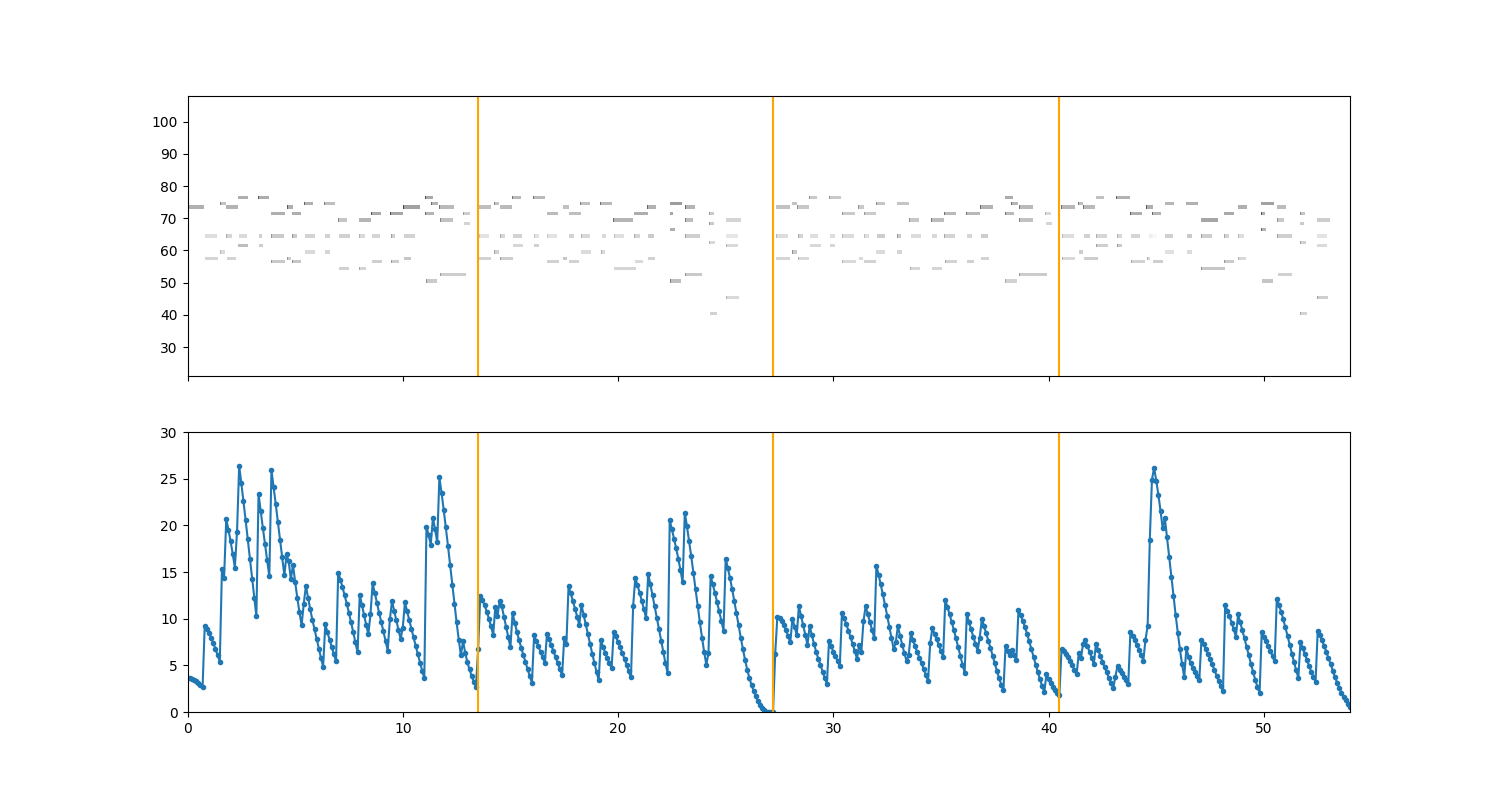

In [33]:
limit_seconds = (0,54)
tps = 40 #ticks pr second
qps =  tempo.qpm/60
tpq = int(tps/qps)

score_quantized = score.resample(tpq=tpq, min_dur=1)

track = score_quantized.tracks[0]
pianoroll = track.pianoroll(modes=["onset", "frame"], encode_velocity=True, pitch_range=pitch_range)
# this will show the onset and frame of the piano roll in one figure

fig, ax = plt.subplots(2,1,figsize=(15, 8), sharex=True)

im = ax[0].imshow(
    pianoroll[0] + pianoroll[1],
    aspect="auto",
    origin="lower", 
    interpolation="none",
    extent=[0, pianoroll[0].shape[1]/tps,*pitch_range],
    # cmap="YlOrBr"
    cmap="binary"
)

ax[0].set_xlim(limit_seconds)
ax[1].plot(timepoints[0], iic_vals, '.-')
ax[1].vlines([13.5, 27.2, 40.5], 0, 60,colors="orange")
ax[0].vlines([13.5, 27.2, 40.5], *pitch_range,colors="orange")
ax[1].set_ylim(0,30)
# Show the plot
# fig.show()
sr = 44100
synth = symusic.Synthesizer(
    sample_rate = sr, # the sample rate of the output wave, 44100 is the default value
)

audio = synth.render(score, stereo=False) 
display(Audio(data=audio[0, slice(*[l*sr for l in limit_seconds])], rate=sr))
# fig.show()